<a href="https://www.kaggle.com/code/nkoidila/loan-status-prediction?scriptVersionId=168220524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-status-prediction/loan_data.csv


In [2]:
data=pd.read_csv('/kaggle/input/loan-status-prediction/loan_data.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


## Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [4]:
#Check for duplicates
data.duplicated().sum()

0

In [5]:
#Check for data with missing values
data.isnull().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
#Dropping the loanId column
data.drop(['Loan_ID'],axis=1,inplace=True)

In [7]:
#Dropping records with missing values in Credit history column
data.dropna(subset=['Credit_History'],inplace=True)


In [8]:
#Filling remaining categorical columns with mode
for column in data.select_dtypes(include='object'):
    data[column].fillna(data[column].mode()[0],inplace=True)
    
data.info()
    

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 380
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             351 non-null    object 
 1   Married            351 non-null    object 
 2   Dependents         351 non-null    object 
 3   Education          351 non-null    object 
 4   Self_Employed      351 non-null    object 
 5   ApplicantIncome    351 non-null    int64  
 6   CoapplicantIncome  351 non-null    float64
 7   LoanAmount         351 non-null    float64
 8   Loan_Amount_Term   340 non-null    float64
 9   Credit_History     351 non-null    float64
 10  Property_Area      351 non-null    object 
 11  Loan_Status        351 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 35.6+ KB


/tmp/ipykernel_19/2977422920.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0],inplace=True)


In [9]:
#Dropping records having missing values for loan amount term
data.dropna(subset=['Loan_Amount_Term'], inplace=True)
data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [10]:
#Isolating categorical columns
categorical_columns=data.select_dtypes(include='object').columns

In [11]:
#Isolating numerical columns
num_columns=data.select_dtypes(exclude='object').columns

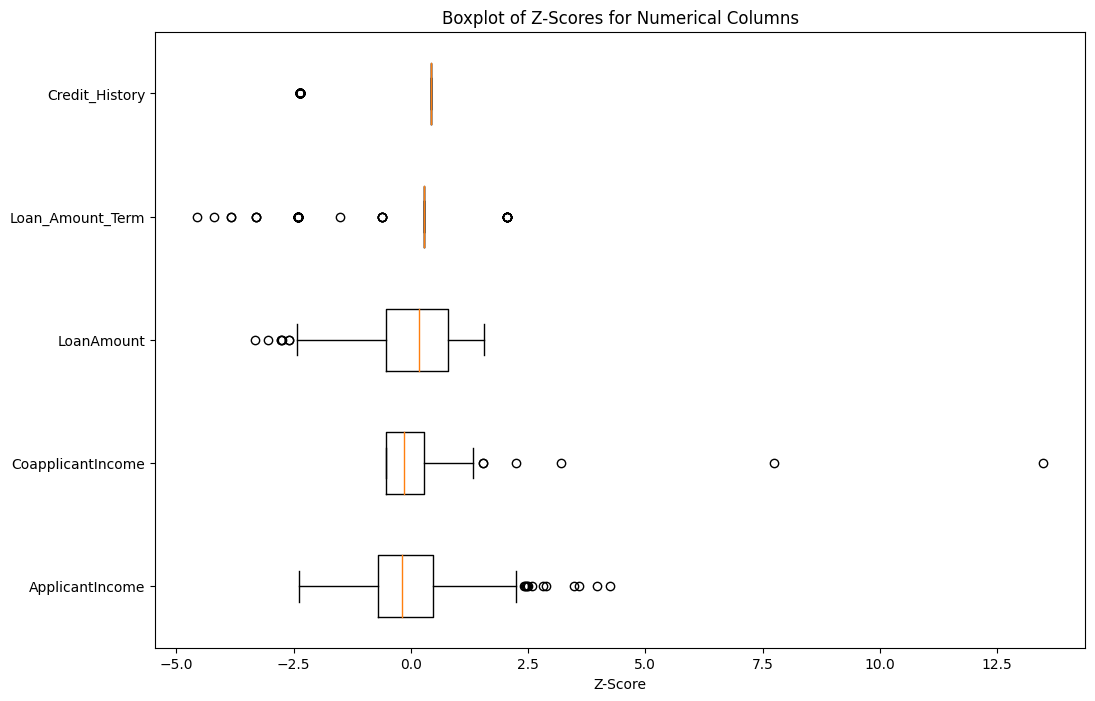

In [12]:
#Checking for outliers
# outlier detection
z_scores = zscore(data[num_columns])

z_scores_df = pd.DataFrame(z_scores, columns=num_columns)

plt.figure(figsize=(12, 8))
plt.boxplot(z_scores_df.values, labels=num_columns, vert=False)
plt.title('Boxplot of Z-Scores for Numerical Columns')
plt.xlabel('Z-Score')
plt.show()

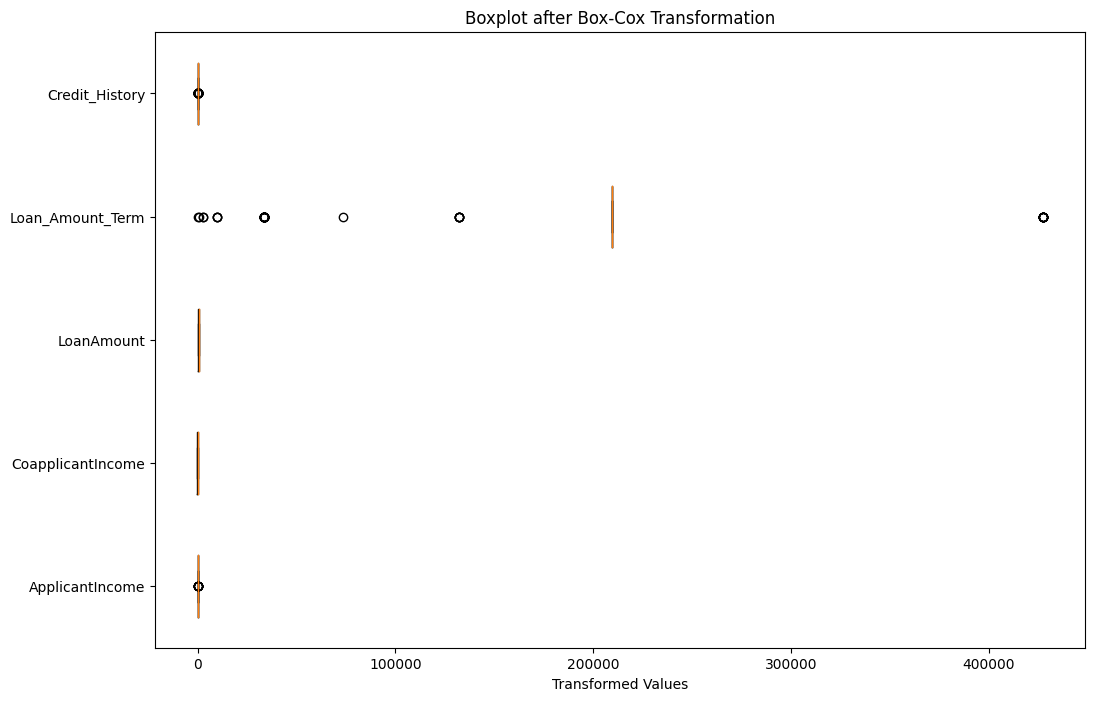

In [13]:
# Define a function to remove outliers using Box-Cox transformation
def remove_outliers_boxcox(data):
    # Added a small constant to handle zero and negative values--close to one
    data = data - data.min() + 1e-6
    transformed_data, _ = boxcox(data)
    return transformed_data

# Apply Box-Cox transformation to numerical columns
transformed_numerical_columns = data[num_columns].apply(remove_outliers_boxcox)
transformed_numerical_columns

# Plot boxplots of the transformed columns
plt.figure(figsize=(12, 8))
plt.boxplot(transformed_numerical_columns.values, labels=num_columns, vert=False)
plt.title('Boxplot after Box-Cox Transformation')
plt.xlabel('Transformed Values')
plt.show()

### Univariate Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


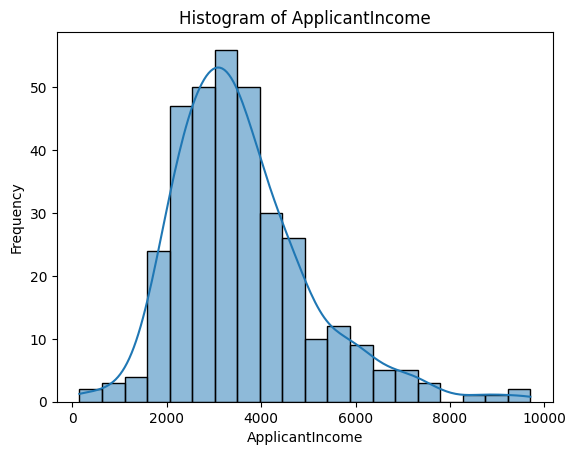

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


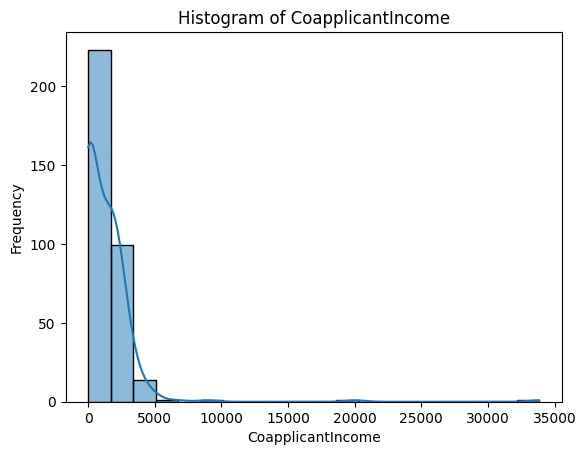

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


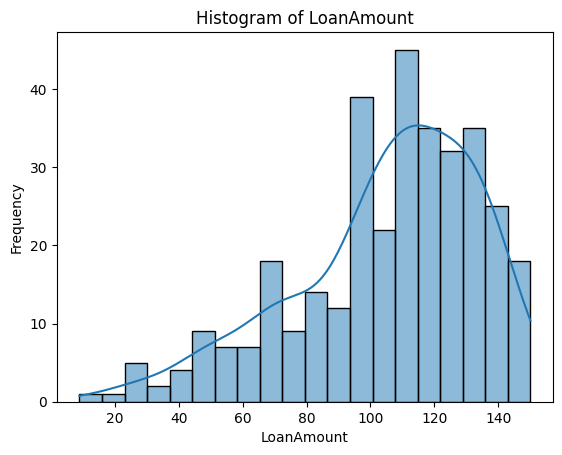

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


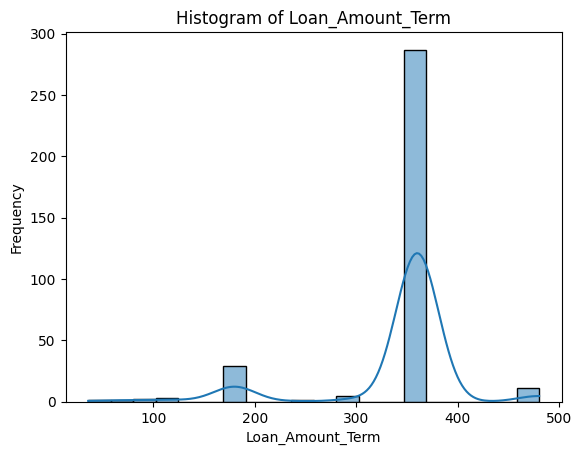

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


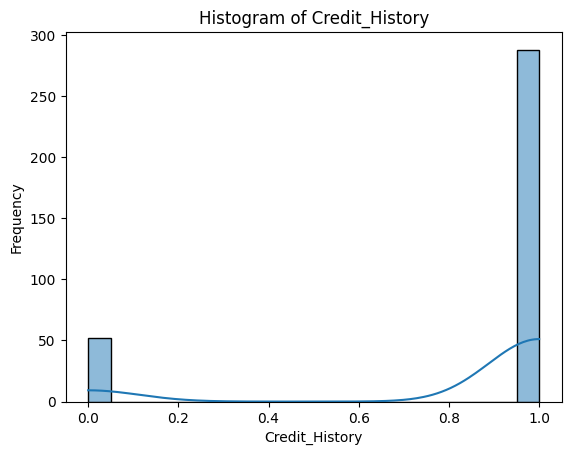

In [14]:
#Histogram to check distribution of numerical data

for column in num_columns:
    sns.histplot(data[column], kde = True, bins = 20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

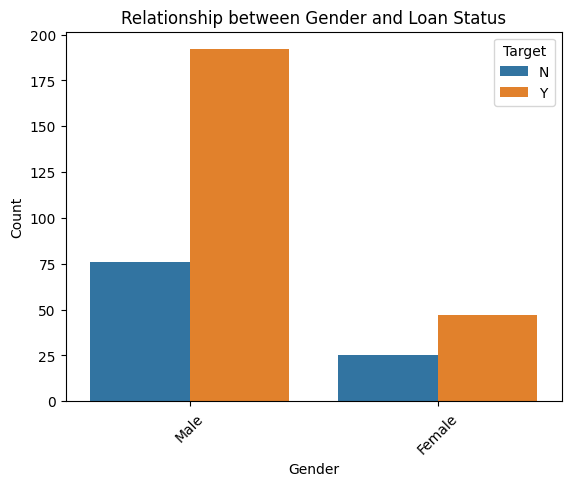

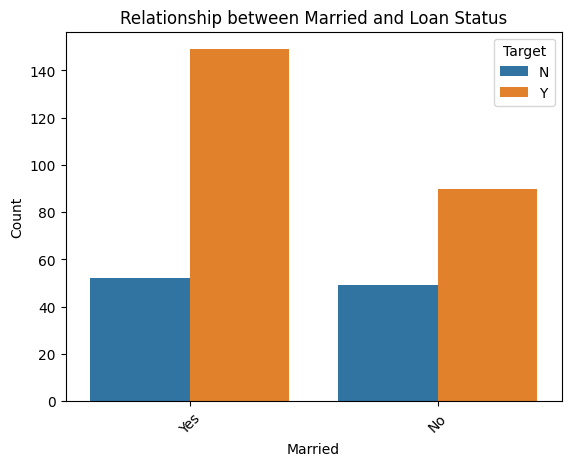

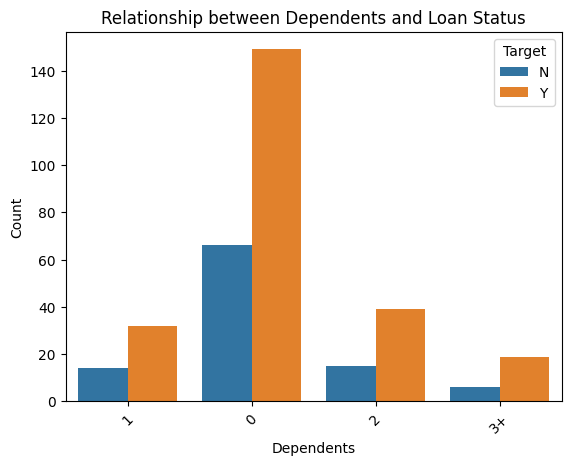

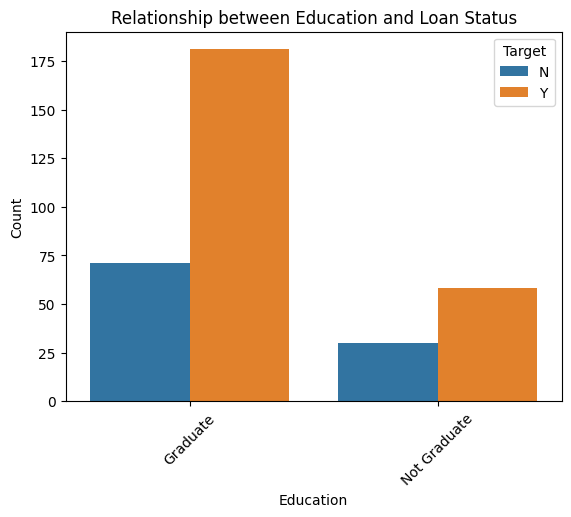

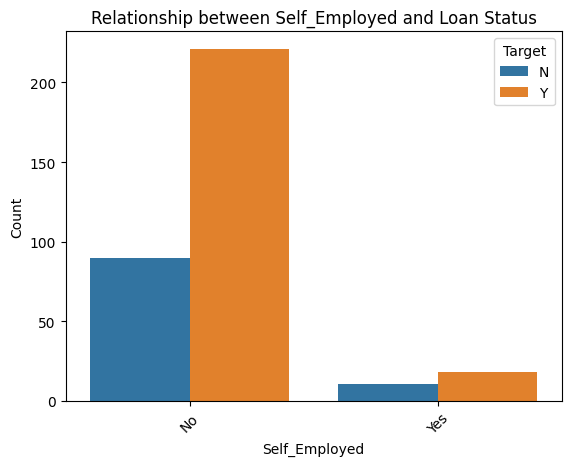

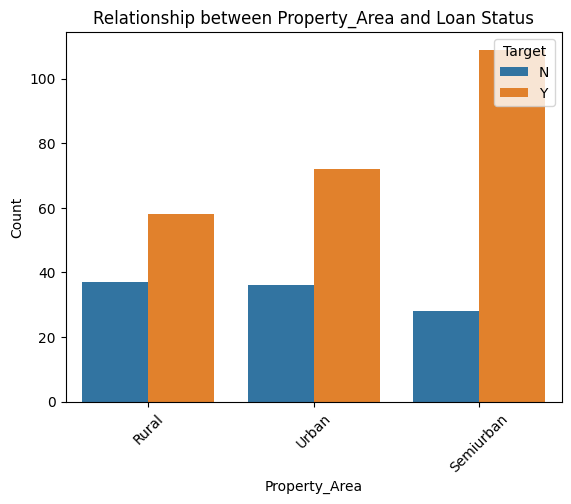

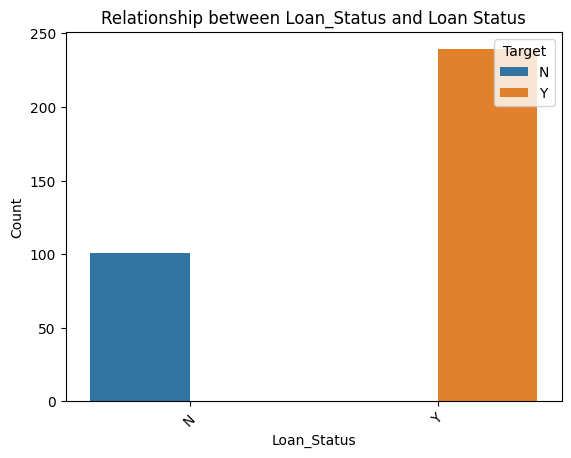

In [15]:
#Checking relationship between categorical values and target variable
for column in categorical_columns:
    sns.countplot(data=data, x=column, hue='Loan_Status')
    plt.title(f'Relationship between {column} and Loan Status')  
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Target', loc='upper right') 
    plt.show()

In [16]:
ordinal_columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']

In [17]:
#Label Encoding ordinal features 
encoder=LabelEncoder()

for column in ordinal_columns:
    data[column]=encoder.fit_transform(data[column])
    

data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
1,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
2,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
3,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
4,1,1,0,1,0,2333,1516.0,95.0,360.0,1.0,2,1


### Data Splitting and Scaling

In [18]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y ,test_size=0.2,random_state=42 )

In [20]:
#Scaling the data
scaler=StandardScaler()

x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=(x_train).columns)
x_test=pd.DataFrame(scaler.fit_transform(x_test),columns=(x_test).columns)

### Fitting and Evaluating the models

In [21]:
#Logistic Regression
model1=LogisticRegression()
model1.fit(x_train,y_train)

LogisticRegression()

In [22]:
#Testing
prediction1=model1.predict(x_test)


In [23]:
#Modelevaluation
report=classification_report(prediction1,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       1.00      0.85      0.92        61

    accuracy                           0.87        68
   macro avg       0.72      0.93      0.76        68
weighted avg       0.94      0.87      0.89        68

